In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

In [2]:
data = pd.read_excel('数据科学实践Data/Grad-NonL.xlsx', header=3)

In [3]:
features = data.drop(columns=['EQV1'])
labels = data['EQV1']

In [4]:
def load_data(batch_size, features, labels):
    features = torch.tensor(features.values.tolist())
    labels = torch.tensor(labels.values.tolist())
    features = (features - features.mean(0)) / features.std(0)
    dataset = TensorDataset(features, labels)
    data_iter = DataLoader(dataset, batch_size, shuffle=True)
    W, b = torch.rand((6, 1), requires_grad=True), torch.rand(1, requires_grad=True)
    return data_iter, W, b    

In [5]:
batch_size, num_epochs, alpha = 1, 50, 0.0001
data_iter, W, b = load_data(batch_size, features, labels)


In [6]:
def sgd(data_iter, num_epochs, alpha, W, b):
    loss = nn.MSELoss()
    optimizer = torch.optim.SGD([W, b], alpha)
    sigmoid = nn.Sigmoid()
    loss_list = []
    for _ in range(num_epochs):
        sum_loss = 0
        for X, y in data_iter:
            optimizer.zero_grad()
            y_hat = sigmoid(torch.mm(X, W) + b)       
            l = loss(y_hat.squeeze(1), y)
            l.backward()
            optimizer.step()
            sum_loss += l.item() / len(y)
        loss_list.append(sum_loss / len(data_iter))
    return loss_list, W, b

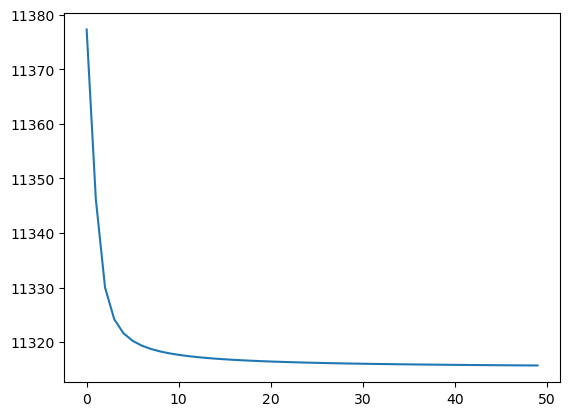

In [7]:
loss_list, W, b = sgd(data_iter, num_epochs, alpha, W, b)
plt.plot(loss_list)

In [8]:
W, b

(tensor([[ 0.0950],
         [-0.2352],
         [ 0.1740],
         [ 0.0300],
         [ 0.0535],
         [-0.0061]], requires_grad=True),
 tensor([5.7871], requires_grad=True))

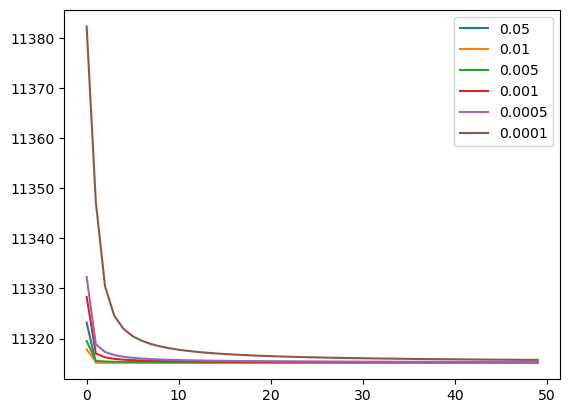

In [9]:
alpha_range = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
list_ = []
for alpha in alpha_range:
    data_iter, W, b = load_data(batch_size, features, labels)
    loss_list, W, b = sgd(data_iter, num_epochs, alpha, W, b)
    list_.append(loss_list)
for i, loss_list in enumerate(list_):
    plt.plot(loss_list, label=alpha_range[i])
plt.legend()
plt.show()

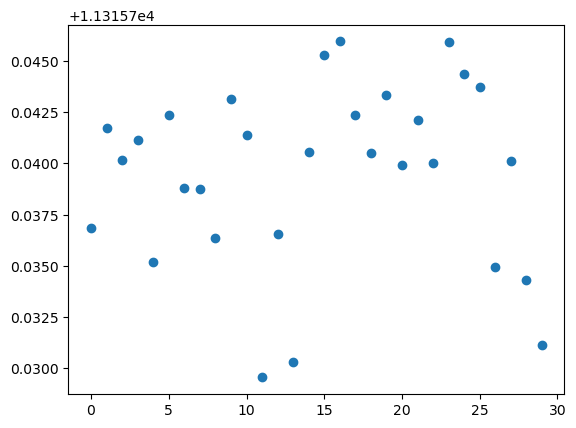

In [10]:
alpha, num_epochs = 0.0001, 50
num_runs, list_ = 30, []
for _ in range(num_runs):
    data_iter, W, b = load_data(1, features, labels)
    list_.append(sgd(data_iter, num_epochs, alpha, W, b)[0])

plt.scatter(list(range(num_runs)), [min(x) for x in list_])

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def newton_method(X, y, max_iter=100, tol=1e-6):
    n_samples, n_features = X.shape
    W = np.zeros(n_features)
    for i in range(max_iter):
        y_hat = sigmoid(np.dot(X, W))

        gradient = np.dot(X.T, (y_hat - y)) / n_samples

        D = np.diag(y_hat * (1 - y_hat))
        Hessian = np.dot(np.dot(X.T, D), X) / n_samples

        if np.linalg.det(Hessian) == 0:
            print("Hessian矩阵不可逆，停止迭代。")
            break

        update = np.linalg.inv(Hessian).dot(gradient)
        W -= update

        if np.linalg.norm(update) < tol:
            print(f"在第{i}次迭代后收敛。")
            break

    return W


X = data.drop(columns='EQV1').values
X_mean, X_std = X.mean(0), X.std(0)
X = (X - X_mean) / X_std
X = np.c_[np.ones(X.shape[0]), X]

y = data['EQV1'].values
y_min = y.min()
y_max = y.max()
y = (y - y_min) / (y_max - y_min)


W = newton_method(X, y)

print("W:", W)

在第4次迭代后收敛。
W: [-0.89111325  0.15021976 -0.56355929  0.36398257  0.01637094 -0.03435915
 -0.08047252]


In [12]:
z = np.dot(X, W)
z = z * (y_max - y_min) + y_min
y_hat = sigmoid(z)
print("mse: ", np.mean((y_hat - data['EQV1'].values) ** 2))

mse:  11437.628214441953
